Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 1  
Due: April 17, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gzip
import numpy as np
from sklearn.linear_model import *
from sklearn.preprocessing import StandardScaler

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib

from hw1 import *
import time

In [3]:
# data_dir="/Users/michellehu/git_dirs/ComplexSystems_AMATH563/data/"
wd="/mnt/Backups/jmhu"

data_dir=wd+"/git_dirs/ComplexSystems_AMATH563/data/"
model_dir=wd+"/git_dirs/ComplexSystems_AMATH563/models/"
fig_dir = wd+"/git_dirs/ComplexSystems_AMATH563/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

## Load data

In [4]:
with open(data_dir+"pickled_mnist.pkl", 'rb') as f:
    trainX, testX, trainY, testY = pickle.load(f)

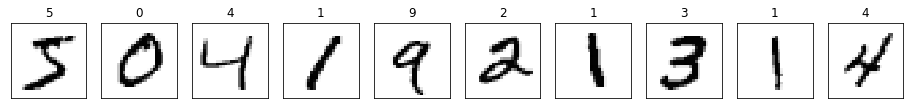

In [5]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY[i])

---

## Normalize data

In [33]:
print(trainX.min(), trainX.max())

scaler = StandardScaler()

trainX_norm = scaler.fit_transform(trainX)
testX_norm = scaler.transform(testX)

trainY = np.array(trainY)
testY = np.array(testY)

print(trainX_norm.min(), trainX_norm.max())

0 255
-1.2742078920822268 244.94693302873063


### Question 1.
Using various AX=B solvers, determine a mapping from the image space (A) to the label space (B)

**Approach:** pick two solvers and vary regularization (guided by exploration runs)

In [7]:
solver_names = [
           "saga_elastic_L1_C01_mult", 
           "saga_elastic_L2_C01_mult",
           "saga_elastic_mix_C01_mult",
           "saga_elastic_half_C01_mult",
           "sgd_elastic_L2_C0005_mult"
          ]

In [8]:
%%time
n_jobs=4
tol=0.01

solvers=[]
l1_ratio = [1, 0, 0.8, 0.5]
multi_class="multinomial"

# saga + varying penalties
# with stochastic average gradient descent and L2 regularization

for i, model in enumerate(solver_names):
    if i+1 < (len(solver_names)):
        model=LogisticRegression(solver="saga", 
                                 multi_class=multi_class, 
                                 C=0.1, 
                                 penalty="elasticnet", 
                                 l1_ratio=l1_ratio[i],
                                 n_jobs=n_jobs, 
                                 tol=tol)
    else:
        model=LogisticRegression(solver="sag", 
                                 multi_class=multi_class, 
                                 C=0.005, 
                                 penalty="l2", 
                                 n_jobs=n_jobs, 
                                 tol=tol)

    solvers.append(model)

CPU times: user 25 µs, sys: 12 µs, total: 37 µs
Wall time: 41 µs


In [9]:
solvers

[LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=1, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0.8, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    war

## Test times without cross-validation

0
189.18 sec elapsed
saga_elastic_L1_C01_mult trained
Saving as hw1_cmsaga_elastic_L1_C01_mult.png
1
68.54 sec elapsed
saga_elastic_L2_C01_mult trained
Saving as hw1_cmsaga_elastic_L2_C01_mult.png
2
186.97 sec elapsed
saga_elastic_mix_C01_mult trained
Saving as hw1_cmsaga_elastic_mix_C01_mult.png
3
180.96 sec elapsed
saga_elastic_half_C01_mult trained
Saving as hw1_cmsaga_elastic_half_C01_mult.png
4
64.52 sec elapsed
sgd_elastic_L2_C0005_mult trained
Saving as hw1_cmsgd_elastic_L2_C0005_mult.png


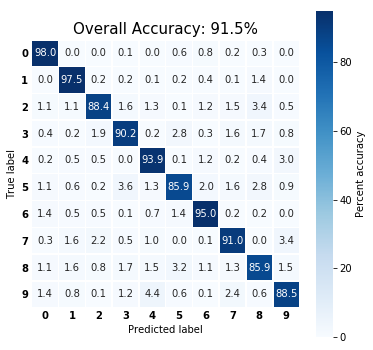

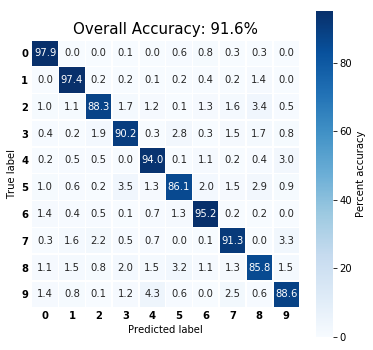

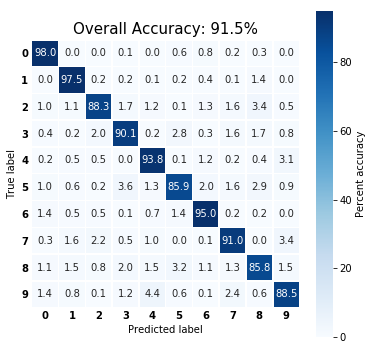

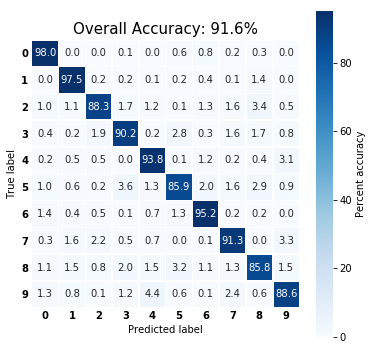

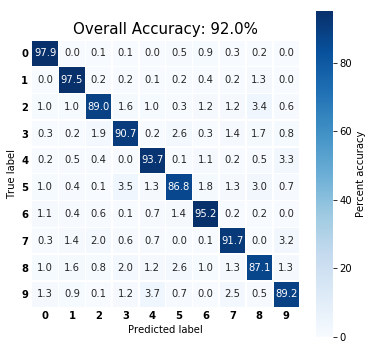

In [10]:
# A is the vectorized MNIST training images
A=trainX_norm.copy()

# B is the set of output vectors
B=trainY.copy()

models = []

# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):
    print(i)
    model_fn=model_dir + model_name + ".pkl"
    
    if os.path.exists(model_fn):
        trained_model = joblib.load(model_fn)
        pred = trained_model.predict(testX_norm)
        acc = trained_model.score(testX_norm, testY)
        
        print("Model exists and loaded")
        
    else:
        start=time.time()
        trained_model, pred, acc = optimize(model, A, B, testX_norm, testY)  
        print("{0:.2f}".format(time.time()-start), "sec elapsed")

        print(model_name, "trained")
        
        joblib.dump(trained_model, model_fn)

    models.append(trained_model)
    
    r, m = compute_loss(trained_model, pred, testX_norm, testY)
    matrices[:, 10*i : 10*i + 10] = m
    reports.append(r)

    fig_name = fig_dir+"hw1_cm" + model_name + ".png"

    plot_confusion(m, acc, save_fn = fig_name)

In [34]:
# Check sparsity of solutions
sparsity_L1 = np.mean(models[0].coef_ == 0)*100
sparsity_L2 = np.mean(models[1].coef_ == 0)*100
sparsity_L1_mix = np.mean(models[2].coef_ == 0)*100
sparsity_L1_half = np.mean(models[3].coef_ == 0)*100
sparsity_sgd = np.mean(models[4].coef_ == 0)*100

print("Sparsity with L1 penalty:", "{0:.2f}".format(sparsity_L1), "%")
print("Sparsity with L2 penalty:", "{0:.2f}".format(sparsity_L2), "%")
print("Sparsity with 0.8 L1 ratio penalty:", "{0:.2f}".format(sparsity_L1_mix), "%")
print("Sparsity with 0.5 L1 ratio penalty:", "{0:.2f}".format(sparsity_L1_half), "%")
print("Sparsity with sgd L2 penalty:", "{0:.2f}".format(sparsity_sgd), "%")

Sparsity with L1 penalty: 24.97 %
Sparsity with L2 penalty: 8.55 %
Sparsity with 0.8 L1 ratio penalty: 23.00 %
Sparsity with 0.5 L1 ratio penalty: 18.61 %
Sparsity with sgd L2 penalty: 8.55 %


### Question 2

Promote sparsity and rank which pixels are most informative for digit labelling. 

### View model sparsity and digit importance with varying L1 penalty ratio using multinomial logistic regression

In [12]:
m_index=2
thisModel = models[m_index]
coef=thisModel.coef_

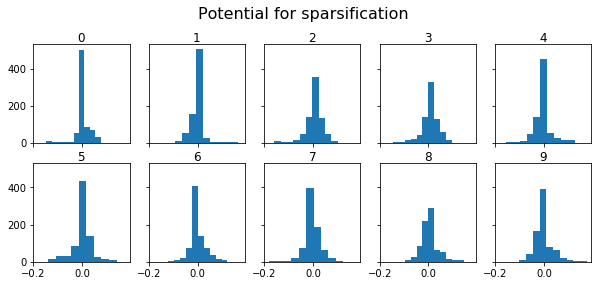

In [13]:
hist_coef(thisModel)

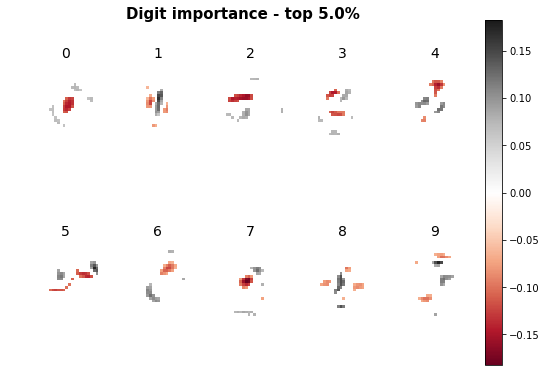

In [14]:
plot_vip(thisModel)

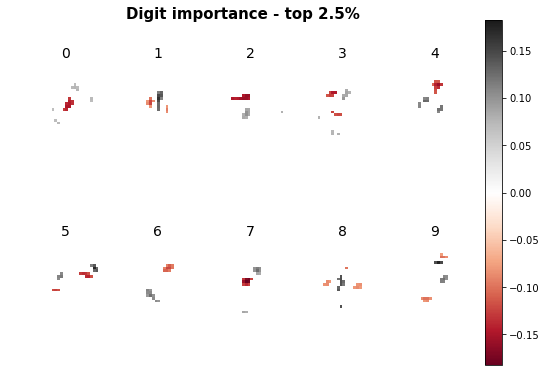

In [15]:
plot_vip(thisModel, p=1.25)

Use L1  
rank the 784 pixels to see which is most informative  
Most informative = largest coefficients in matrix X (trained_model.coef_) --> top 5% of pixels, visualized

### Rank pixels in single image to show most informative for digit labelling using LASSO

In [35]:
%%time

# Use non-normalized pixels for training
A = trainX.copy()
B = trainY.copy()

model=Lasso(tol=tol)
model_name="lasso"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc = optimize(model, A, B, testX, testY)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

joblib.dump(trained_model, model_fn)

1.69 sec elapsed
CPU times: user 18.5 s, sys: 7.52 s, total: 26 s
Wall time: 1.71 s


In [36]:
trained_model

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

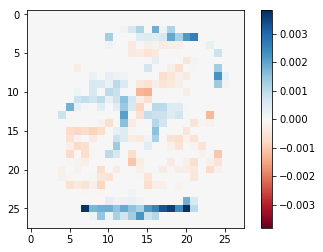

In [37]:
# Visualize important pixels using LASSO regression
A_lasso = trained_model.coef_.copy()

clim=max(np.abs(A_lasso.min()), np.abs(A_lasso.max()))
plt.imshow(A_lasso.reshape(28,28), vmin=-clim, vmax=clim, cmap="RdBu")
plt.colorbar()

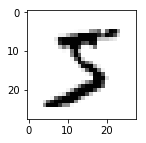

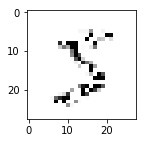

In [38]:
# Use A_lasso coefficients to mask training data
X=trainX.copy()

A_lasso_mask = A_lasso == 0

plt.figure(figsize=(2,2))
plt.imshow(X[0].reshape(28,28), plt.cm.Greys)
plt.figure(figsize=(2,2))
plt.imshow(np.ma.masked_where(A_lasso_mask, X[0]).reshape(28,28), plt.cm.Greys)

In [39]:
%%time
# extract new training dataset
new_X_byLASSO=np.empty_like(X)

for f in range(X.shape[0]):
    new_X_byLASSO[f, A_lasso_mask] = X[f,:][A_lasso_mask] 

CPU times: user 318 ms, sys: 4.11 ms, total: 323 ms
Wall time: 322 ms


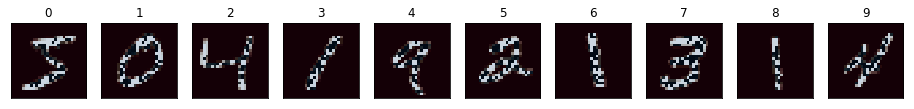

In [40]:
# Check out the new training set
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = new_X_byLASSO[i,:].reshape(28,28)
    img2 = X[i,:].reshape(28,28)    
    ax.imshow(img2, cmap="RdBu")
    ax.imshow(img, cmap="Greys_r", alpha=0.8)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)

### Question 3
Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

### Use logistic regression model relying on non-zero LASSO coefficient pixels as mask for training data

188.26 sec elapsed
Saving as hw1_cmlasso_pick_saga_mix_C01_mult.png
CPU times: user 3min 10s, sys: 1.39 s, total: 3min 11s
Wall time: 3min 8s


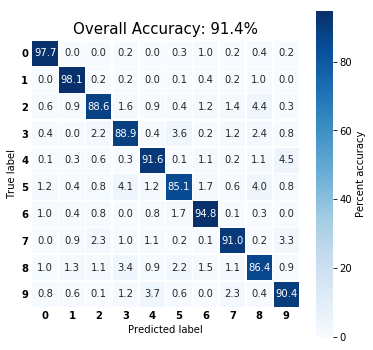

In [42]:
%%time

# Use important pixels as training matrix
A = new_X_byLASSO
B = trainY

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

model_name="lasso_pick_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc = optimize(model, A, B, testX, testY)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir+"hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

joblib.dump(trained_model, model_fn)

In [43]:
sparsity_LASSO_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with LASSO digit extraction and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_LASSO_mix), "%")

Sparsity with LASSO digit extraction and 0.8 L1 ratio penalty: 50.18 %


### Add normalization to the classification portion

165.03 sec elapsed
Saving as hw1_cmlasso_pick_normX_saga_mix_C01_mult.png
CPU times: user 2min 46s, sys: 1.32 s, total: 2min 48s
Wall time: 2min 45s


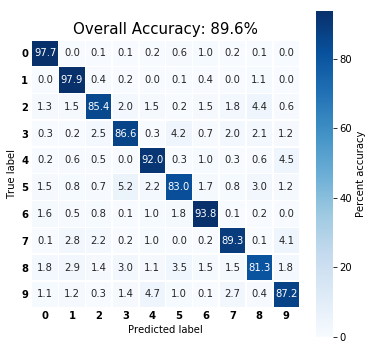

In [44]:
%%time

# extract new normalized training dataset
new_X_byLASSO=np.empty_like(trainX_norm)

for f in range(trainX_norm.shape[0]):
    new_X_byLASSO[f, A_lasso_mask] = trainX_norm[f,:][A_lasso_mask] 
    
# Use important pixels as training matrix
A = new_X_byLASSO
B = trainY

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

model_name="lasso_pick_normX_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc = optimize(model, A, B, testX_norm, testY)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir+"hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

joblib.dump(trained_model, model_fn)

In [45]:
sparsity_LASSO_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with LASSO digit extraction, normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_LASSO_mix), "%")

Sparsity with LASSO digit extraction, normalization and 0.8 L1 ratio penalty: 51.11 %


### Question 4
Redo the analysis with each digit individually to find the most important pixels for each digit.

#### Create training set for each digit using nonzero SAGA coefficients

0


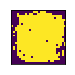

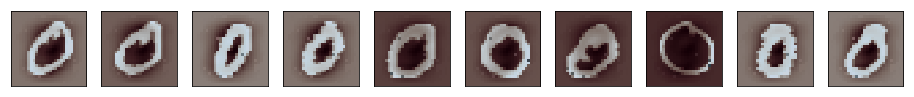

1


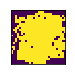

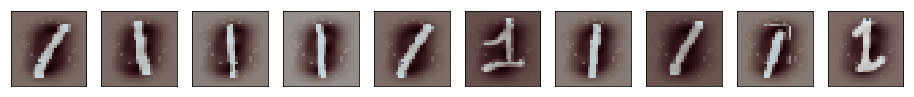

2


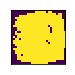

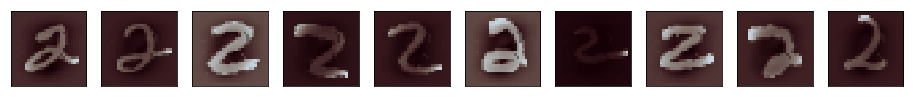

3


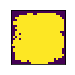

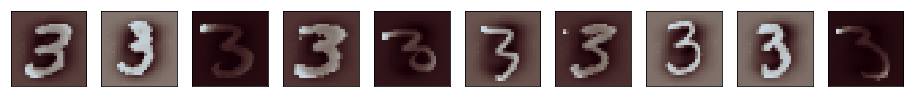

4


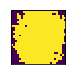

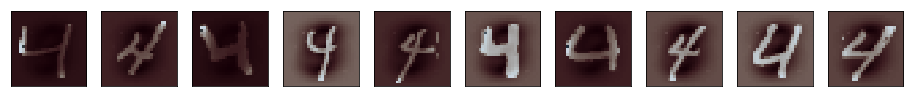

5


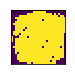

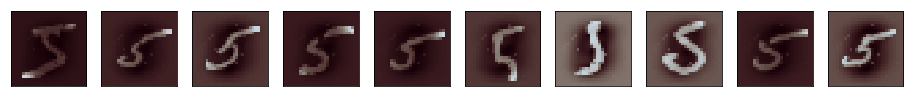

6


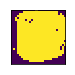

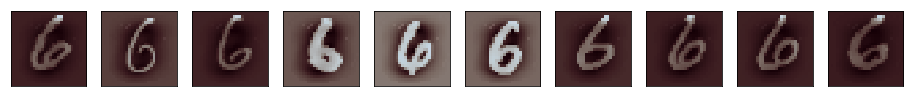

7


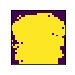

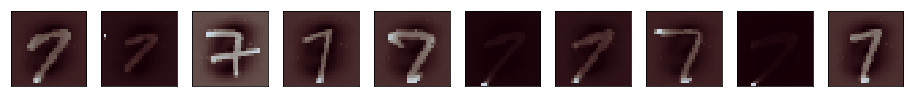

8


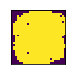

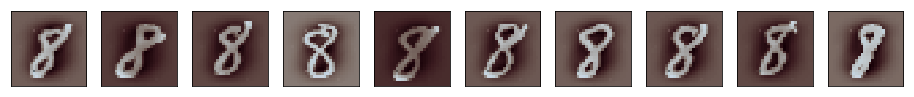

9


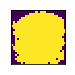

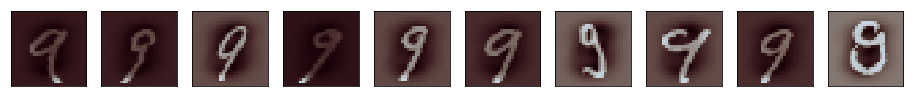

345.60 sec elapsed
lasso_pick_normX_vip_digit_nonzero_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_normX_vip_digit_nonzero_saga_mix_C01_mult.png


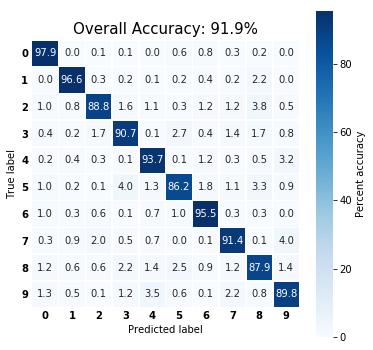

In [104]:
coef=thisModel.coef_

indices=[]

testX_digits=testX_norm.copy()
trainX_digits=trainX_norm.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] == 0)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure(figsize=(1,1))
    plt.imshow(test_img.reshape(28,28))    
    plt.xticks(())
    plt.yticks(())
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_normX_vip_digit_nonzero_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    pred = trained_model.predict(testX_norm)
    acc = trained_model.score(testX_norm, testY)

    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc = optimize(model, A, B, testX_norm, testY)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")

    print(model_name, "trained")

    joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [105]:
sparsity_digits_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction (all nonzero) and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_digits_mix), "%")

Sparsity with individual digit extraction (all nonzero) and 0.8 L1 ratio penalty: 21.61 %


## without normalization

0


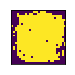

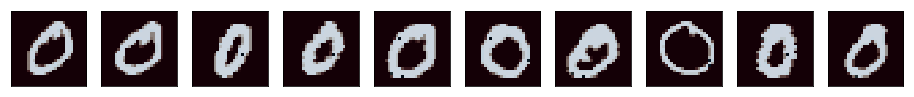

1


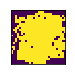

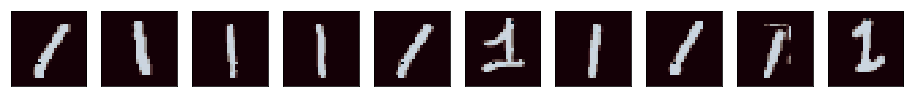

2


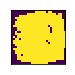

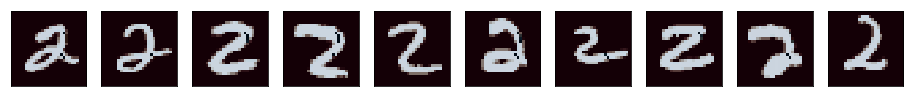

3


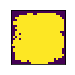

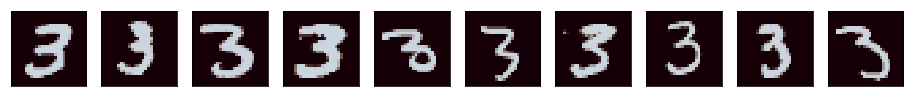

4


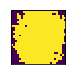

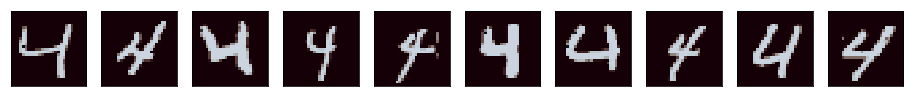

5


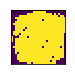

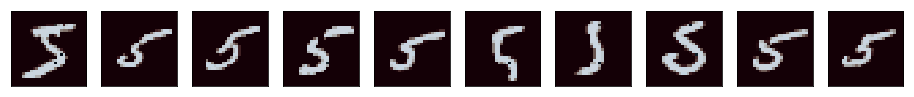

6


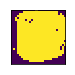

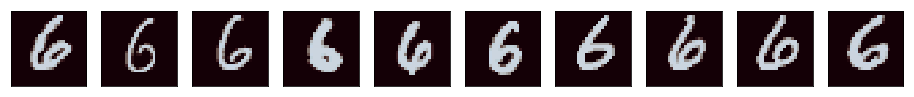

7


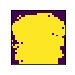

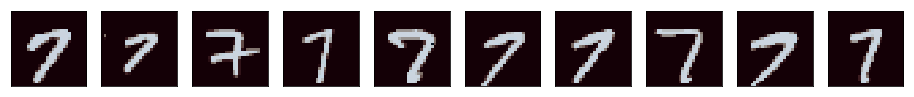

8


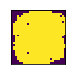

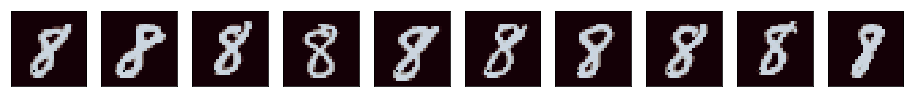

9


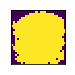

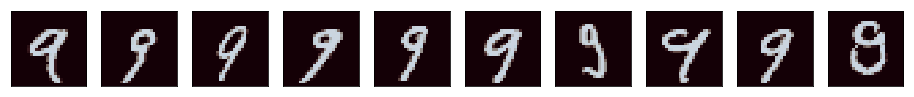

169.60 sec elapsed
lasso_pick_vip_digit_nonzero_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_vip_digit_nonzero_saga_mix_C01_mult.png


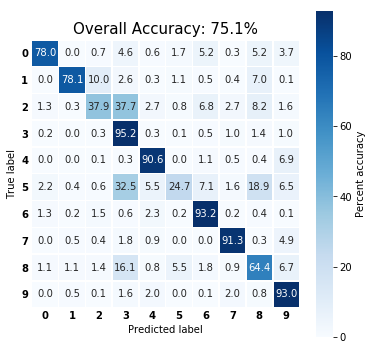

In [106]:
coef=models[2].coef_

indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] == 0)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure(figsize=(1,1))
    plt.imshow(test_img.reshape(28,28))    
    plt.xticks(())
    plt.yticks(())
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_vip_digit_nonzero_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    pred = trained_model.predict(testX)
    acc = trained_model.score(testX, testY)

    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc = optimize(model, A, B, testX, testY)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")

    print(model_name, "trained")

    joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [107]:
sparsity_digits_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction (all nonzero), normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_digits_mix), "%")

Sparsity with individual digit extraction (all nonzero), normalization and 0.8 L1 ratio penalty: 22.42 %


#### 10% of coefficients

0


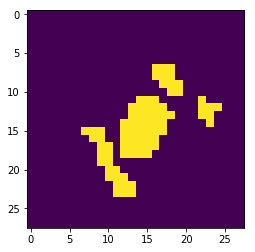

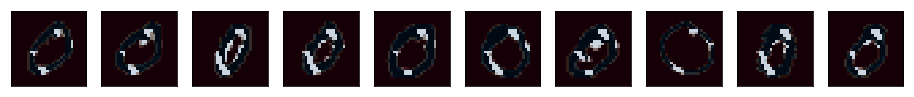

1


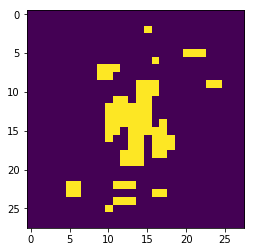

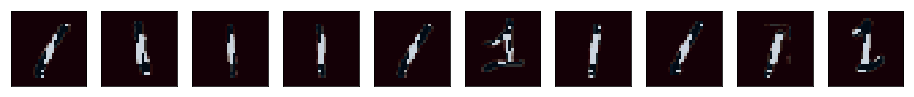

2


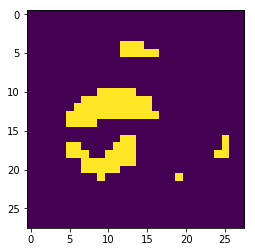

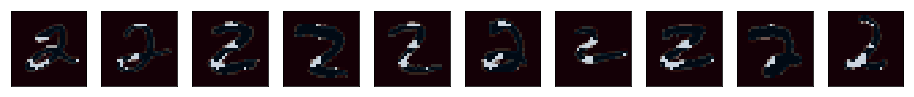

3


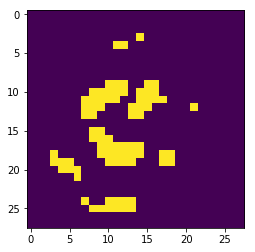

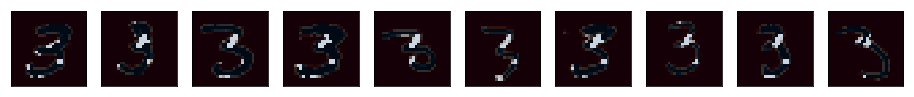

4


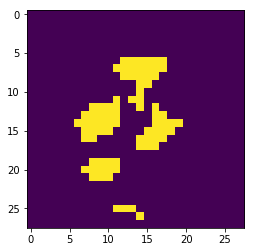

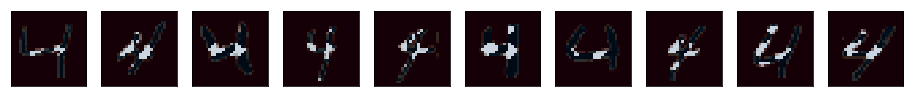

5


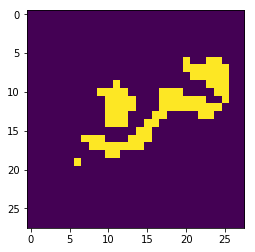

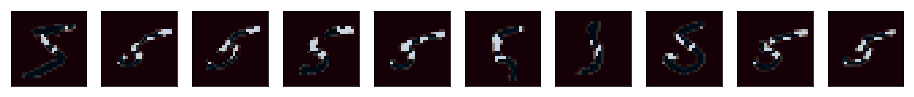

6


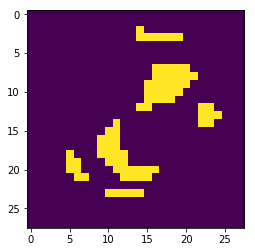

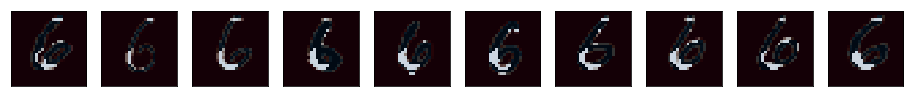

7


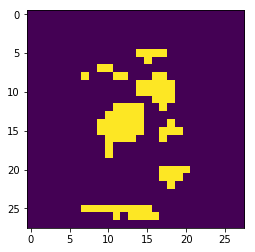

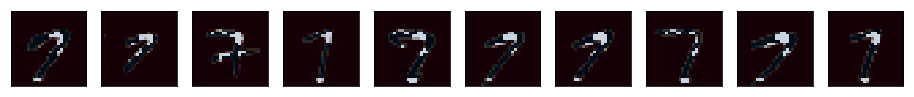

8


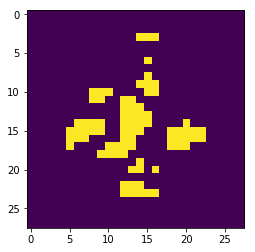

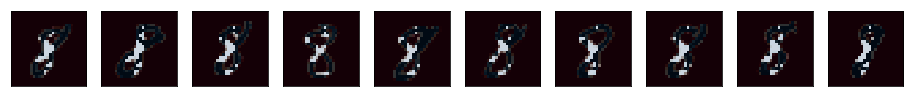

9


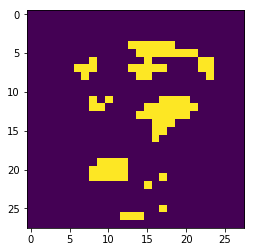

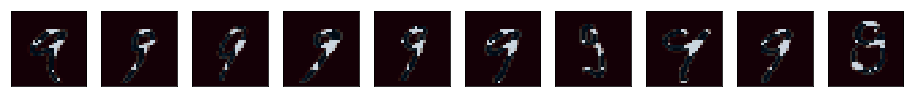

86.34 sec elapsed
lasso_pick_vip_digit_10perc_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_vip_digit_10perc_saga_mix_C01_mult.png


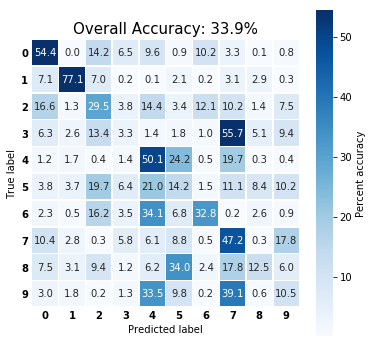

In [108]:
coef=models[2].coef_

p=5
indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_vip_digit_"+str(2*p)+"perc_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

start=time.time()
trained_model, pred, acc = optimize(model, A, B, testX, testY)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

print(model_name, "trained")

joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [110]:
sparsity_vip_digits_10percent_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction, top 10% of coefficients and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_vip_digits_10percent_mix), "%")

Sparsity with individual digit extraction, top 10% of coefficients and 0.8 L1 ratio penalty: 64.67 %


### With normalization

0


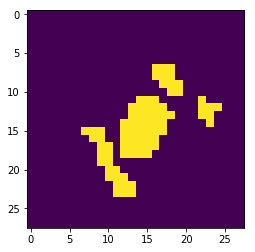

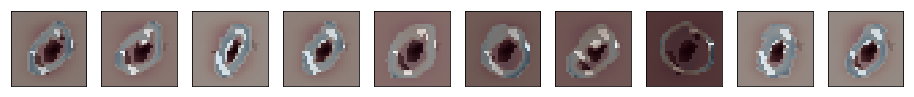

1


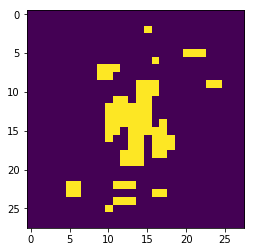

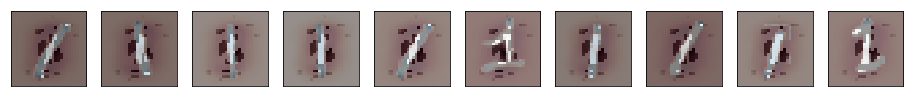

2


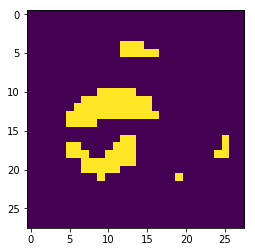

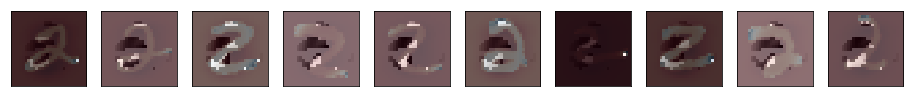

3


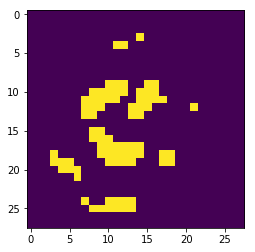

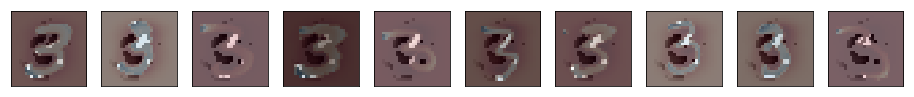

4


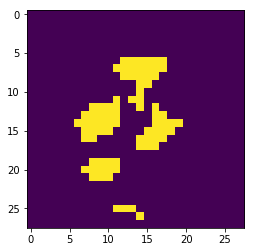

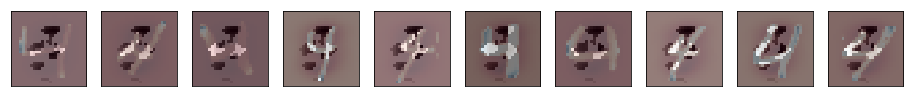

5


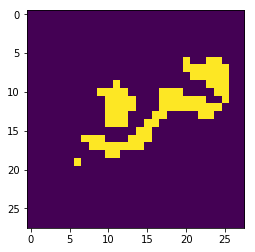

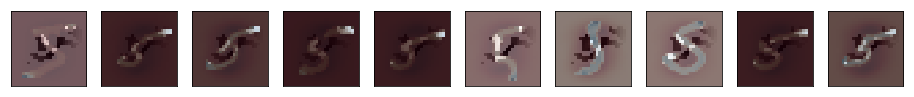

6


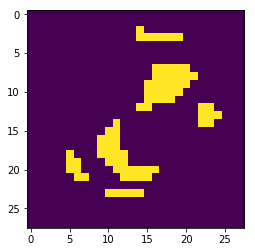

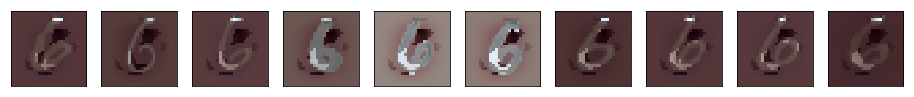

7


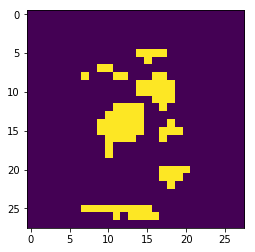

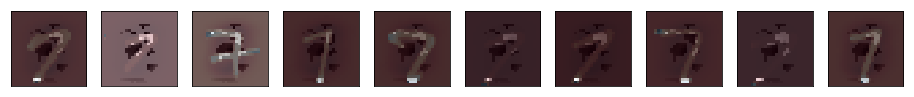

8


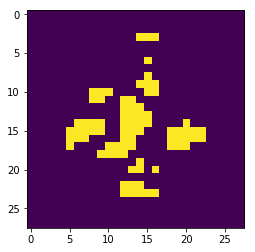

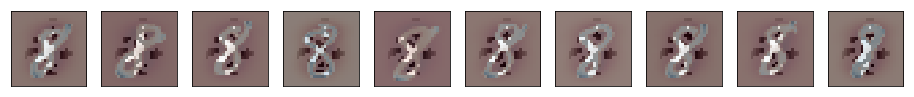

9


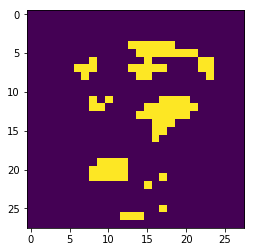

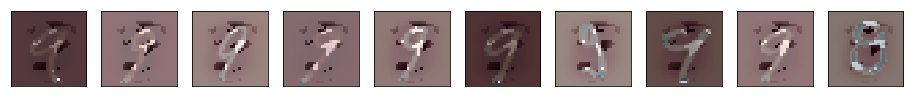

115.03 sec elapsed
lasso_pick_vip_digit_10perc_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_vip_digit_10perc_saga_mix_C01_mult.png


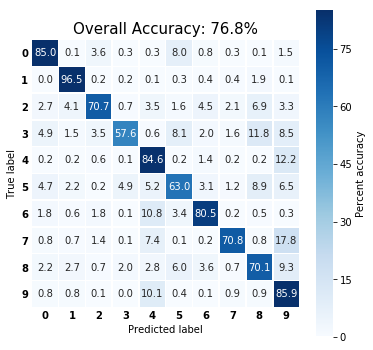

In [111]:
coef=models[2].coef_

p=5
indices=[]

testX_digits=testX_norm.copy()
trainX_digits=trainX_norm.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_vip_digit_"+str(2*p)+"perc_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

start=time.time()
trained_model, pred, acc = optimize(model, A, B, testX_norm, testY)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

print(model_name, "trained")

joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [112]:
sparsity_vip_digits_10percent_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction, top 10% of coefficients, normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_vip_digits_10percent_mix), "%")

Sparsity with individual digit extraction, top 10% of coefficients, normalization and 0.8 L1 ratio penalty: 88.70 %


## BONUS

#### Do this with one-vs-rest appropach

63.77 sec elapsed
saga_elastic_mix_C01_ovr trained
Saving as hw1_cmsaga_elastic_mix_C01_ovr.png


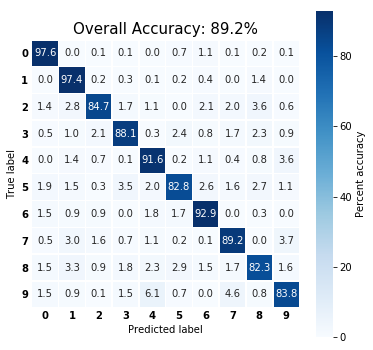

In [117]:
A = trainX_norm
B = trainY

model=LogisticRegression(solver="saga", 
                                 multi_class='ovr', 
                                 C=0.1, 
                                 penalty="elasticnet", 
                                 l1_ratio=0.8,
                                 n_jobs=n_jobs, 
                                 tol=tol)
model_name="saga_elastic_mix_C01_ovr"

model_fn=model_dir + model_name + ".pkl"

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    pred = trained_model.predict(testX_norm)
    acc = trained_model.score(testX_norm, testY)

    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc = optimize(model, A, B, testX_norm, testY)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")

    print(model_name, "trained")

    joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [119]:
sparsity_ovr = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with ovr normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_ovr), "%")

Sparsity with ovr normalization and 0.8 L1 ratio penalty: 15.18 %


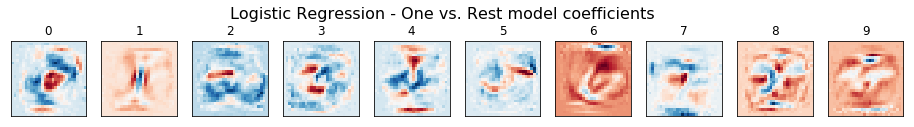

In [120]:
# Check out ovr digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trained_model.coef_[i].reshape((28,28))
    ax.imshow(img, cmap="RdBu")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)
plt.suptitle("Logistic Regression - One vs. Rest model coefficients", fontsize=16, y=0.75);

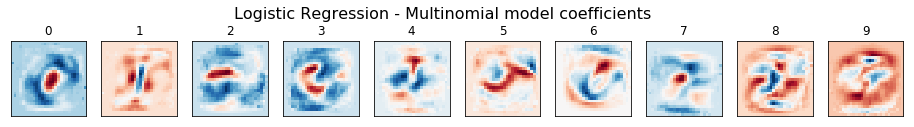

In [116]:
# Check out multinomial digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = models[2].coef_[i].reshape((28,28))
    ax.imshow(img, cmap="RdBu")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)
plt.suptitle("Logistic Regression - Multinomial model coefficients", fontsize=16, y=0.75);

### Question 5
Think about the interpretation of what you are doing with this AX = B problem.


f(x) = something
A = trainX (observations)
B = trainY (labels)

X = beta = loadings so we can transform (i.e. map) A (e.g. data, observations, images) into B (e.g. labels)
The way I've been doing this above has been using 10 different X's -- 
see this https://towardsdatascience.com/kannada-visual-model-952cc6ec3a72 and this https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html